In [24]:
import ipywidgets
import pandas as pd
import numpy as np
import sys
from ipywidgets import widgets,Button, HBox, VBox, Box, Layout
from IPython.display import Javascript, display
from pyspark.sql.functions import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

# Automated Test-Control Store Selection 

# Making X5 Changes

In [25]:
import os
os.chdir('/nfs/science/shared/ipythonNotebooks/vaibhat/SR/c3')
os.getcwd()

'/nfs/science/shared/ipythonNotebooks/vaibhat/SR/c3'

In [26]:
from pyspark.sql import HiveContext
import pandas as pd
df=pd.read_csv('cluster1t.csv')
sample=sqlContext.createDataFrame(df)
df = sample.withColumn("fis_week_id",concat(lit("sales"),lit("_"),col("fis_week_id")))

sample_pivot = df.groupBy("store_code").pivot("fis_week_id").sum("sales").na.fill(0)
sample_pivot.toPandas().to_csv("testrunt.csv",encoding='latin',index = False)



In [27]:
df_data = pd.read_csv("testrunt.csv",encoding='latin')

#df_data["store_code"] = df_data.store_code.map("{:05}".format)

In [28]:
df = pd.DataFrame(['cluster1'],columns= list("c"))
pilot_stores = pd.DataFrame(df.c.apply(lambda x: str(x).zfill(5)))
pilot_stores

,c
0,cluster3


In [29]:
df_data2=df_data.T
df_data3=df_data2.rename(columns=df_data2.iloc[0])
df_data3=df_data3.iloc[1:]
df_data3=df_data3.astype(float)
df_corr=df_data3.corr()
df_corr[df_corr==1]=0
df_corr2 = df_corr.unstack().reset_index(name='correlation').sort_values(by=['level_0', 'correlation'], ascending=[True, False])
df_corr2.index = range(len(df_corr2))
df_corr2['Corr_Rank'] = df_corr2.groupby('level_0')['correlation'].rank(ascending=False)
#df_corr2

In [30]:
# df_data_v2=df_data
df_data.index = df_data['store_code']
a1=df_data.iloc[:,1:]
a1= 1-pd.DataFrame(pairwise_distances(a1, metric="cosine")).round(5)
a1.index = df_data['store_code']
a1=a1.rename(columns=df_data2.iloc[0])
a1[a1==1]=0
a1=a1.unstack().reset_index(name='cosine_similarity').sort_values(by=['level_0', 'cosine_similarity'], ascending=[True, False])
a1.index = range(len(a1))
a1['Cossim_Rank'] = a1.groupby('level_0')['cosine_similarity'].rank(ascending=False)
#a1

In [31]:
combined = pd.merge(a1, df_corr2, left_on = ['level_0','store_code'], right_on = ['level_0','level_1']).drop(['level_1'],axis=1)
# combined 

# Use Groupby and Count on above dataset to Output Potential Trial Stores with Quality

In [32]:
reduced3 = pd.merge(combined, pilot_stores, left_on = 'level_0', right_on = 'c').drop(['c'],axis=1)
elim_trail=pilot_stores['c'].tolist()
reduced4 = reduced3.drop(reduced3[reduced3['store_code'].isin(elim_trail)].index).reset_index().drop(['index'],axis=1)

In [33]:
reduced4.to_csv('all_res3.csv')

# Individual Store level matching as below :-

In [60]:
# %%time
from scipy.spatial.distance import cosine
cnt=0
Test_dict={}
Control_dict={}
Error_dict={}
Correlation_dict={}
CosineSim_dict={}
Testdata_dict={}
Controldata_dict={}

for i in elim_trail:
    cnt=cnt+1
#     print ("Test store "+str(cnt)+" : "+i)
    process_df = reduced4.drop(reduced4[reduced4.level_0 <> i].index).reset_index().drop(['index'],axis=1)
    process_df = process_df.drop(process_df[process_df.cosine_similarity < 0.9975].index).reset_index().drop(['index'],axis=1)
    process_df = process_df.drop(process_df[process_df.correlation < 0.55].index).reset_index().drop(['index'],axis=1)
    process_df['weighted_scr'] = process_df['cosine_similarity']*0.95+process_df['correlation']*0.05
    process_df = process_df.sort_values(by=['weighted_scr'], ascending=[False]).reset_index().drop(['index'],axis=1)
    pot_controls=process_df['store_code'].tolist()
#     print (pot_controls)
    if len(pot_controls)>0:        
#     print (process_df)
        new=df_data.iloc[:,1:]
        T=new.loc[i]
        Testdata_dict[cnt-1] = T.to_frame()
        Testdata_dict[cnt-1] = Testdata_dict[cnt-1].rename(columns={ Testdata_dict[cnt-1].columns[0]: "Test" })
        Test_dict[cnt-1]=i
        X = {}
        Er = []
        Cor = []
        Ct = []
        count=0
        for j in pot_controls:
            count = count+1
            if count>5:
                break
            C=new.loc[j]
            AF=T.sum()/C.sum()
            AC=C*AF
            X[count] = AC.to_frame()
            X[count] = X[count].rename(columns={ X[count].columns[0]: "control" })
            P = pd.Panel(X)
            AAC=P.mean(axis=0)
            AACN = AAC.iloc[:,0]
            E=(T-AACN).abs()
            PSE=(E.sum())/(AC.sum())*100
            Er.append(PSE)
            Cor.append(T.corr(AACN))
            if Er[count-1]>Er[count-2] and Cor[count-1]<(Cor[count-2]+0.03):
                break
#             print ("Control "+str(count)+" -> "+str(j))
#             print ("Error : "+ str(PSE))
#             print ("Correlation : "+str(T.corr(AACN)))
#             print ("Cosine Similarity : "+ str(1 - cosine(T,AACN)))
            Ct.append(str(j))
#             print (Ct)
            Controldata_dict[cnt-1]=AAC
            Error_dict[cnt-1]=PSE.round(2)
            Correlation_dict[cnt-1]=T.corr(AACN).round(2)
            CosineSim_dict[cnt-1]=(1 - cosine(T,AACN)).round(4)
            Control_dict[cnt-1]=Ct
collate=pd.DataFrame([Test_dict,Control_dict, Error_dict,Correlation_dict,CosineSim_dict])
final=collate.T
labels=['test','control','error','correlation','trend']
final.columns = labels
final['quality'] = np.where((final['correlation']>0.9) & (final['trend']>0.999) , 'excellent',np.where((final['correlation']>0.85) & (final['trend']>0.9985) , 'good', 'medium'))
final.to_csv('Test_Control_Storewise_Matcht.csv')
final2 = final[['test','control','quality']]
# print ("Individual Store level matching as below :-")
print (final2)
# final2
Q = pd.Panel(Testdata_dict)
T_Group=Q.sum(axis=0)
R = pd.Panel(Controldata_dict)
C_Group=R.sum(axis=0)
tests=T_Group['Test'].tolist()
controls=C_Group['control'].tolist()
TC_plot = pd.DataFrame({'Control': controls,'Test': tests})
TC_plot.to_csv('Test_Control_Group_Datat.csv')
OCR=(T_Group.iloc[:,0].corr(C_Group.iloc[:,0]).round(3))*100
OCS= (1 - cosine(T_Group.iloc[:,0],C_Group.iloc[:,0])).round(4)

       test                         control    quality
0  cluster3  [4992, 5112, 6020, 5176, 5118]  excellent


In [61]:
Testdata_dict

{0:                      Test
 sales_201802  1293249.771
 sales_201803  1301598.180
 sales_201804  1347316.304
 sales_201805  1398162.331
 sales_201806  1541796.873
 sales_201807  1544949.849
 sales_201808  1477311.634
 sales_201809  1344787.720
 sales_201810  1252144.405
 sales_201811  1341966.854
 sales_201812  1350536.442
 sales_201813  1235876.880
 sales_201814  1359092.010
 sales_201815  1213018.551
 sales_201816  1383083.650}

In [62]:
final

,test,control,error,correlation,trend,quality
0,cluster3,"[4992, 5112, 6020, 5176, 5118]",1.93,0.95,0.9997,excellent


In [ ]:
# from pivottablejs import pivot_ui
# pivot_ui(test_control_data)

In [ ]:
#TC_plot

Overall Correlation : 94.8%
Overall Trend Match : 0.9997


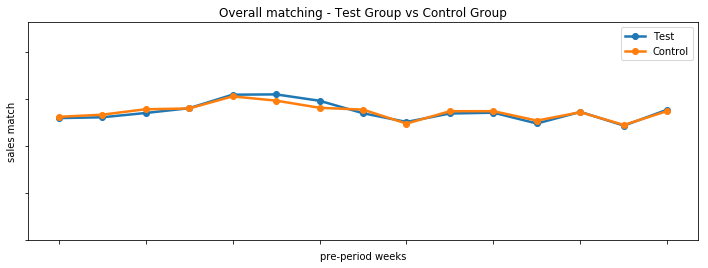

In [63]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# import matplotlib.pyplot as plt
y_max=(TC_plot['Test'].mean()*1.7).round()
y_max
TC_line=TC_plot.plot.line(x=None, y=['Test','Control'],figsize=(12,4),legend=True,linewidth=2.5,marker='o',ylim=(0,y_max),title='Overall matching - Test Group vs Control Group')
TC_line.axes.get_xaxis().set_ticklabels([])
TC_line.axes.get_yaxis().set_ticklabels([])
TC_line.set_xlabel('pre-period weeks')
TC_line.set_ylabel('sales match')
# plt.xticks(x," ")
# plt.xticks(x," ")
# plt.show()
print ("Overall Correlation : " + str(OCR)+"%")
print ("Overall Trend Match : " + str(OCS))

In [64]:
reduced4.head()

,level_0,store_code,cosine_similarity,Cossim_Rank,correlation,Corr_Rank
0,cluster3,5112,0.99942,1.0,0.879158,35.0
1,cluster3,4992,0.99928,2.0,0.884513,30.0
2,cluster3,5176,0.99927,3.0,0.851772,44.0
3,cluster3,5118,0.99924,4.0,0.839250,45.0
4,cluster3,6020,0.99923,5.0,0.879897,34.0
